# Lab 7  - Recap Exercises for Exam

# ❗❗❗ Very important administrative detail

The lab changes its content once every **TWO WEEKS**.

*   week 1 & week 2 - lab 1
*   week 3 & week 4 - lab 2
*   week 5 & week 6 - lab 3
*   week 7 & week 8 - lab 4
*   week 9 & week 10 - lab 5
*   week 11 & week 12 - lab 6
*   week 13 & week 14 - lab 7


# Exercise 1

The number of heads out of 100 coin tosses is 40 and we want to monitor the bias of the coin. Write a prior in PyMC that you would use in modeling given the likelihood:


```
heads = pm.Binomial('heads', n=100, p=theta, observed=40)
```



In [ ]:
# answer:
theta=pm.Beta(1,1)

# Exercise 2

Write the PyMC (complete) code to compute the bias of a 6-sided dice when you know that in 60 throws you get the following results:
   * no. of 1s: 11
   * no. of 2s: 12
   * no. of 3s: 10
   * no. of 4s: 6
   * no. of 5s: 9
   * no. of 6s: 12


In [ ]:
# answer:
import pymc as pm
import arviz as az

counts=[11,12,10,6,9,12]
alpha=[1,1,1,1,1,1]
with pm.Model():
  p=pm.Dirichlet("p", a=alpha)
  likelihood=pm.Multinomial("obs", n=sum(counts), p=p,observed=counts)
  trace=pm.sample(draws=1000, tune=1000, chains=2)


Output()

In [ ]:
az.summary(trace, var_names=["p"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.183,0.049,0.100,0.279,0.001,0.001,2452.0,1346.0,1.0
p[1],0.196,0.047,0.117,0.286,0.001,0.001,2315.0,1552.0,1.0
p[2],0.168,0.046,0.088,0.256,0.001,0.001,2495.0,1548.0,1.0
p[3],0.104,0.036,0.044,0.175,0.001,0.001,1709.0,982.0,1.0
p[4],0.152,0.043,0.078,0.236,0.001,0.001,2405.0,1487.0,1.0
p[5],0.197,0.048,0.113,0.290,0.001,0.001,2332.0,1536.0,1.0


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

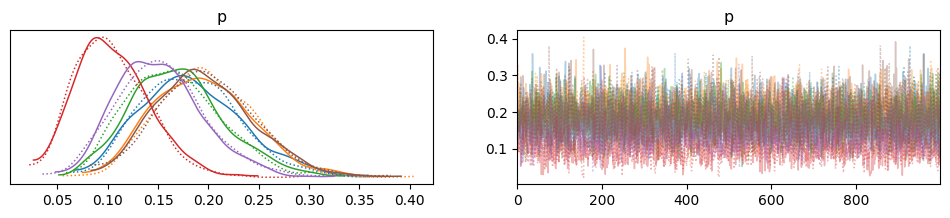

In [ ]:
az.plot_trace(trace, var_names=["p"])

# Exercise 3

A fire prevention checklist contains $N$ boxes to check. $N$ changes depending on legislature and you are part of a team detecting a change point in the number of checkboxes during the years. Write the PyMC likelihood term that you should use knowing that the observed data is stored in array y_obs.


In [ ]:
# answer:
likelihood=pm.Poisson("likelihood", mu=lam, observed=y_obs)

# Exercise 4

Model this Bayesian Network in PyMC that simulates two alarms in a modern steel foundry factory. The observed data is $C=1$. Compute the posteriors for M (Maufacturing Alarm) and S (Security Alarm).


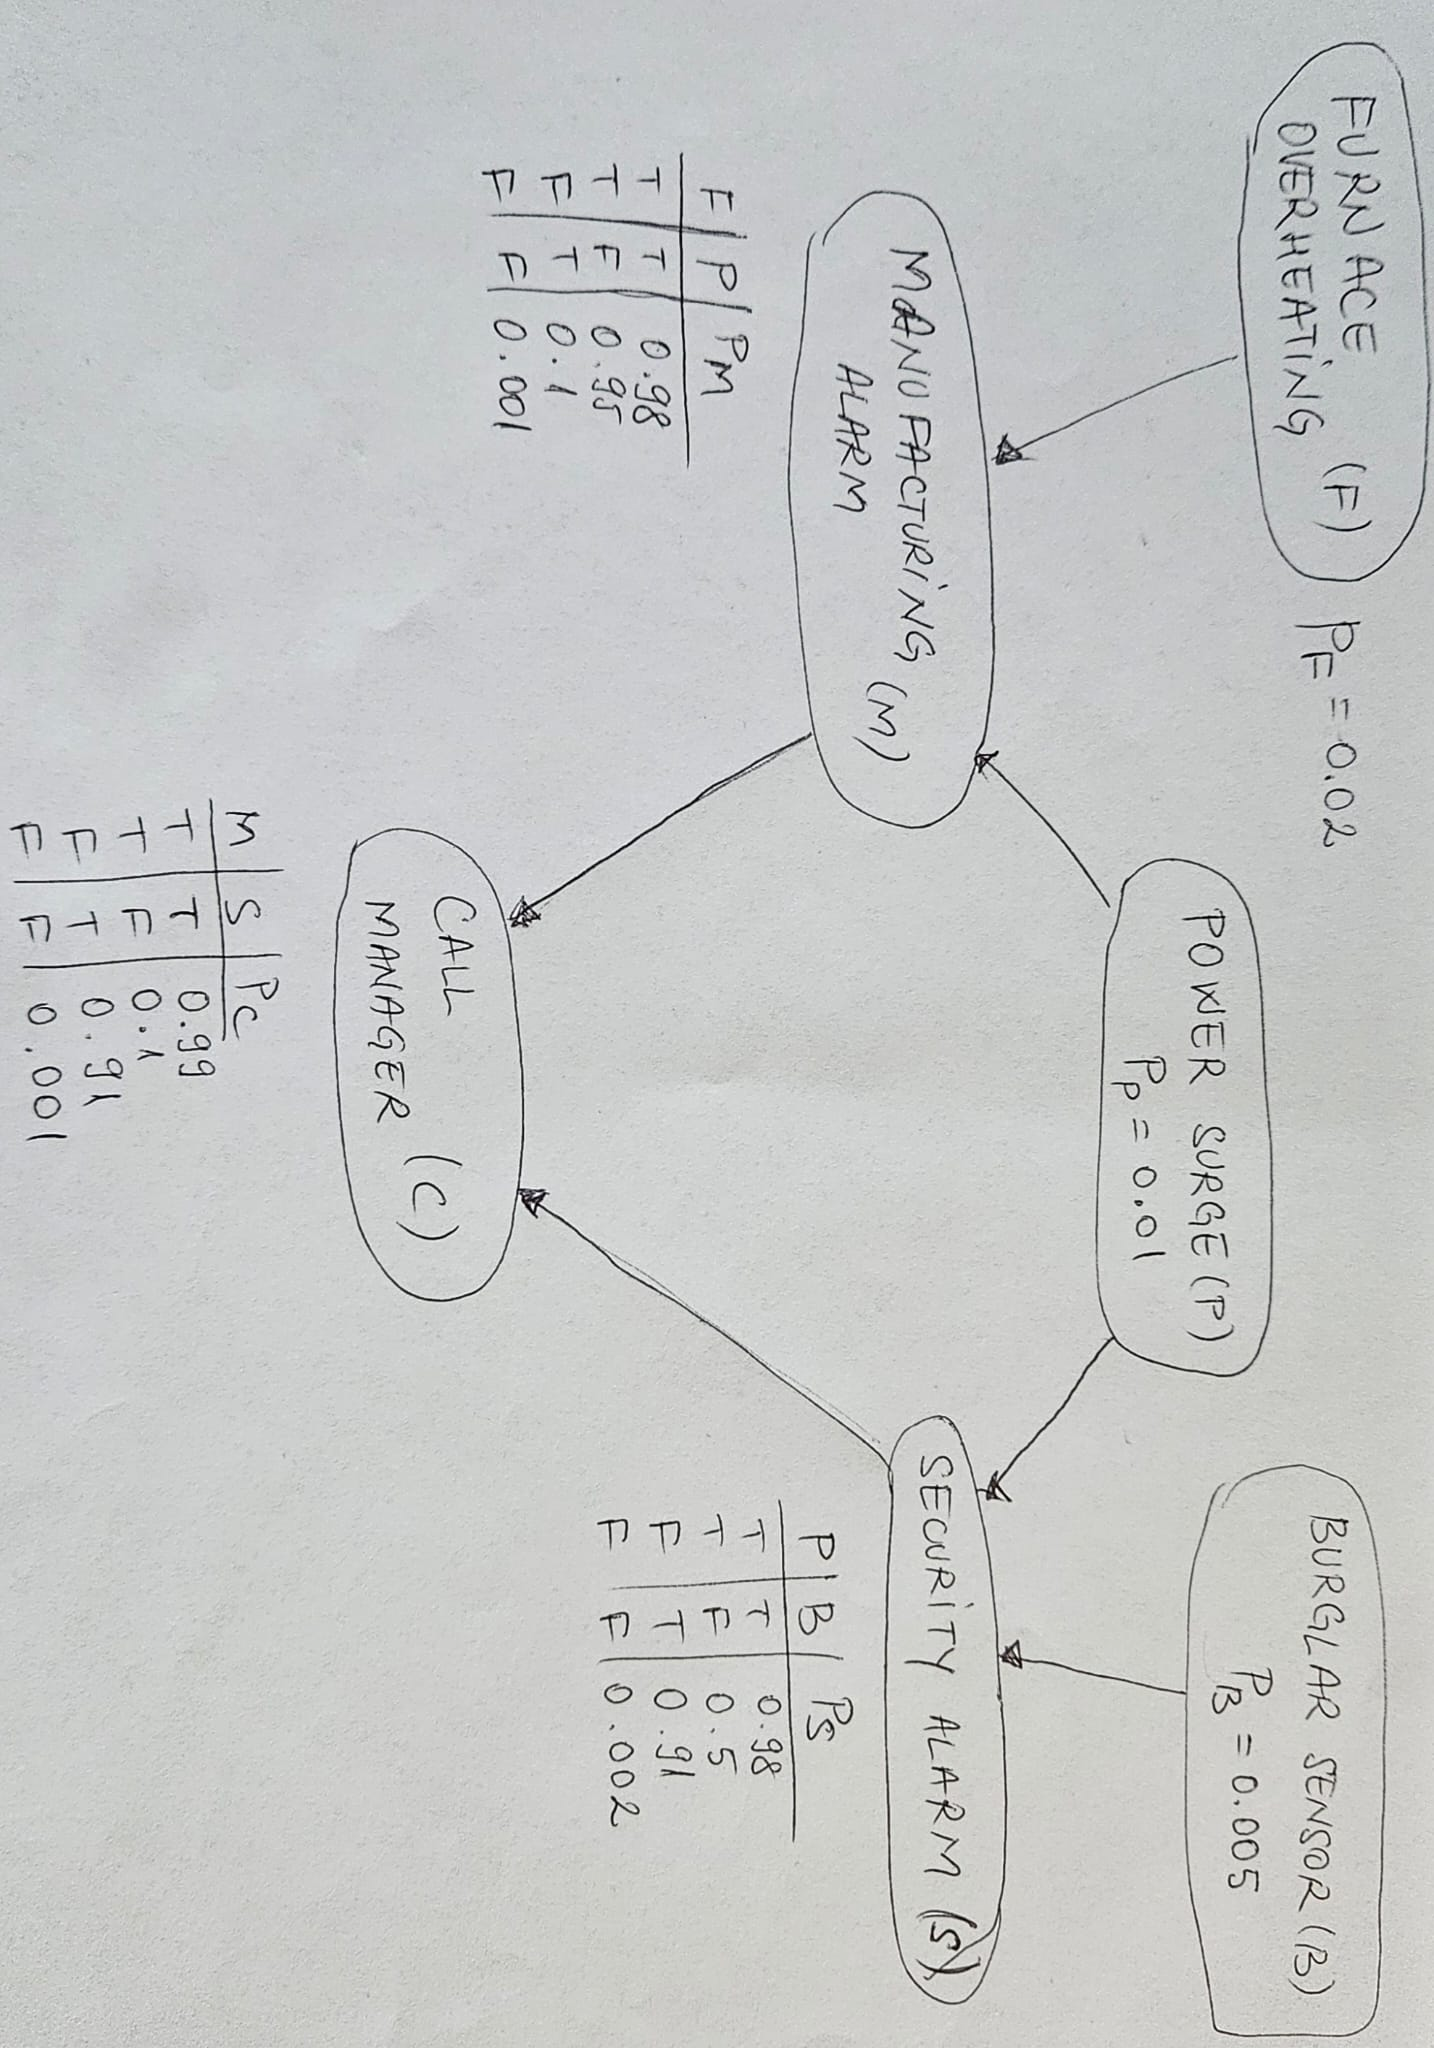

In [ ]:
from IPython.display import Image
Image('BN.jpeg')

In [ ]:
import pymc as pm

with pm.Model():

  F=pm.Bernoulli("F", p=0.02)
  P=pm.Bernoulli("P", p=0.01)
  B=pm.Bernoulli("B", p=0.005)

  p_M=pm.math.switch(F, pm.math.switch(P,0.98,0.95), pm.math.switch(P,0.1,0.001))
  M=pm.Bernoulli("M", p_M)

  p_S=pm.math.switch(P, pm.math.switch(B,0.98,0.5), pm.math.switch(B,0.91,0.002))
  S=pm.Bernoulli("S", p_S)

  p_C=pm.math.switch(M, pm.math.switch(S,0.99,0.1),pm.math.switch(S,0.91,0.001))
  C=pm.Bernoulli("C", p_C, observed=1)

  trace=pm.sample(draws=4000, tune=2000, chains=2)



Output()

array([<Axes: title={'center': 'M'}>, <Axes: title={'center': 'S'}>],
      dtype=object)

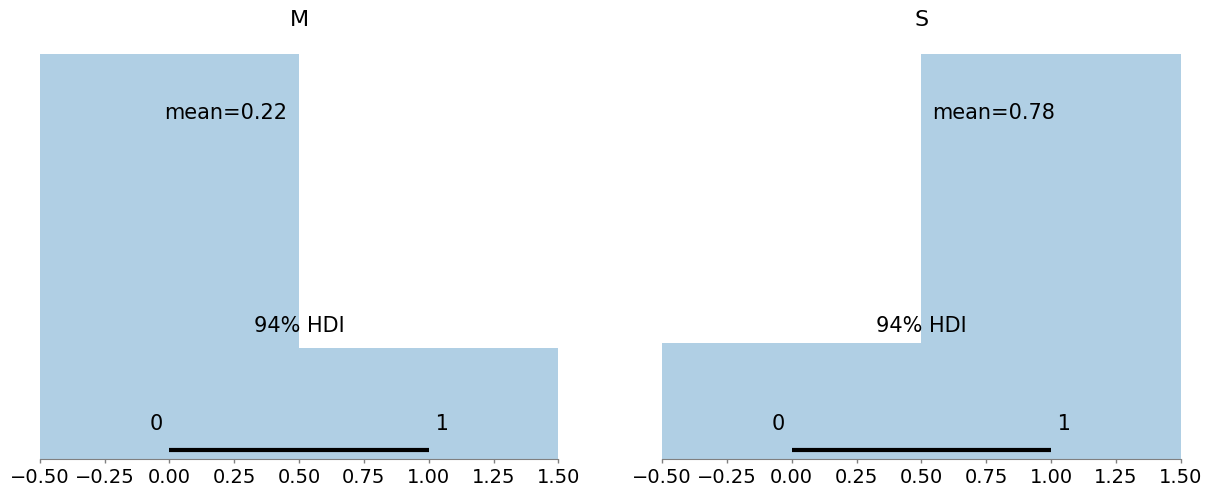

In [ ]:
import arviz as az

az.plot_posterior(trace, var_names=['M', 'S'])

In [ ]:
az.summary(trace, var_names=["M", "S"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M,0.215,0.411,0.0,1.0,0.022,0.015,353.0,353.0,1.0
S,0.777,0.416,0.0,1.0,0.020,0.014,421.0,421.0,1.0


## Posterior Analysis

Given the evidence that the manager was called (C=1), we can interpret the posterior distributions for each alarm:

### Manufacturing Alarm (M)
- P(M=1 | C=1) ≈ 0.22

### Security Alarm (S)
- P(S=1 | C=1) ≈ 0.78

### Interpretation

The security alarm is much more likely to have triggered the call than the manufacturing alarm. This makes intuitive sense when we look at the conditional probability table for C:

- If only S=1: P(C=1) = 0.91
- If only M=1: P(C=1) = 0.1

Since the security alarm has a much stronger influence on whether the manager gets called, observing a call shifts our belief heavily toward S being the cause.

# Exercise 5

For an experiment, 20 basketball players from two teams (team A and team B) make 100 attempts to score 2-pointers. The number of achieved 2-pointer shots is recorded in a dataset for each player in the following csv:



```
player_id, team_name, 2p_achieved
John Doe, team A, 25
Alice, team B, 35
Frank, team A, 15
Bob, team B, 10
...
```
Marge wants to join one of the teams but is unsure which one is better. Help her decide using PyMC and bayesian inference.


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt


In [14]:
df=pd.read_csv("basketball_2pointers.csv")
two_pointers=df["2p_achieved"].to_numpy().T
player_names=df["player_id"]
coords={"player_names":player_names.to_list()}

In [16]:
# answer:
with pm.Model(coords=coords) as basketball:
  phi=pm.Uniform("phi",lower=0,upper=1)

  kappa_log=pm.Exponential("kappa_log", lam=1.5)
  kappa=pm.Deterministic("kappa", pt.exp(kappa_log))

  theta=pm.Beta("theta", alpha=kappa*phi, beta=kappa*(1.0-phi), dims="player_names")

  y=pm.Binomial("obs", n=100, p=theta, dims="player_names",observed=two_pointers)

  trace=pm.sample(draws=3000, tune=1000, target_accept=0.98, chains=2)

Output()

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

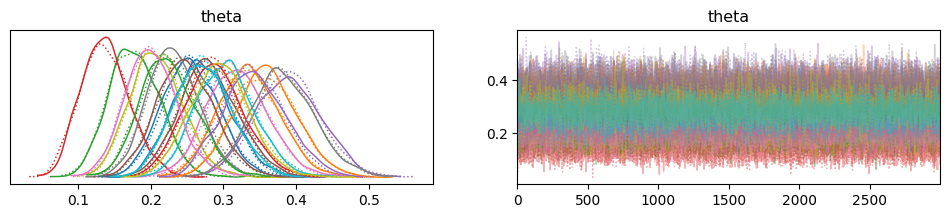

In [17]:
az.plot_trace(trace, var_names=["theta"])

In [18]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kappa,28.348,13.509,7.600,51.656,0.218,0.265,3623.0,3548.0,1.0
kappa_log,3.241,0.456,2.372,4.083,0.008,0.006,3623.0,3548.0,1.0
phi,0.279,0.023,0.239,0.323,0.000,0.000,5922.0,4361.0,1.0
theta[John Doe],0.256,0.039,0.181,0.327,0.000,0.001,8735.0,3777.0,1.0
theta[Alice],0.335,0.042,0.253,0.411,0.000,0.001,8718.0,4118.0,1.0
theta[Frank],0.178,0.035,0.115,0.243,0.000,0.000,6214.0,4936.0,1.0
theta[Bob],0.138,0.034,0.075,0.200,0.000,0.000,6499.0,4275.0,1.0
theta[Marcus],0.389,0.045,0.309,0.478,0.001,0.001,7908.0,4592.0,1.0
theta[Diana],0.280,0.040,0.203,0.352,0.000,0.001,9438.0,4071.0,1.0
theta[Steve],0.319,0.042,0.241,0.397,0.000,0.001,11494.0,4706.0,1.0


In [24]:
theta_samples = trace.posterior["theta"]

team_A = df.loc[df["team_name"] == "team A", "player_id"]
team_B = df.loc[df["team_name"] == "team B", "player_id"]

theta_A = theta_samples.sel(player_names=team_A.values)
theta_B = theta_samples.sel(player_names=team_B.values)

team_A_means = theta_A.mean(dim="player_names")
team_B_means = theta_B.mean(dim="player_names")

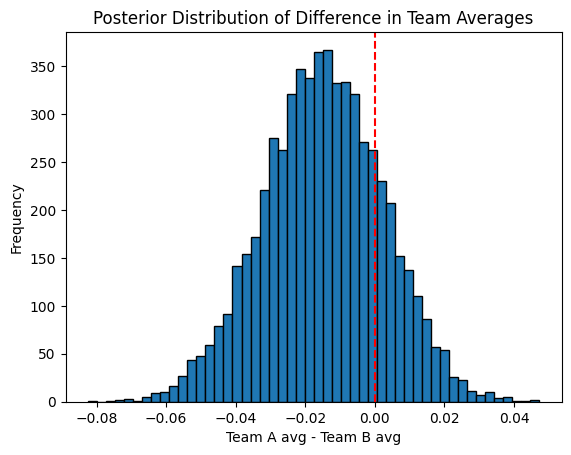

In [26]:
diff = team_A_means - team_B_means

plt.hist(diff.values.flatten(), bins=50, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Team A avg - Team B avg")
plt.ylabel("Frequency")
plt.title("Posterior Distribution of Difference in Team Averages")
plt.show()

In [27]:
prob_B_better = (diff < 0).mean().values
print(f"P(Team B > Team A) = {prob_B_better:.3f}")

P(Team B > Team A) = 0.804
